In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

In [2]:
DATA_DIR = "data"

## Data

In [3]:
headlines_df = pd.read_csv(os.path.join(DATA_DIR, "headlines-with-latlon.csv"))
headlines_df.head()

,headline,city,countrycode,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667


In [4]:
latitudes = headlines_df["latitude"].values
longitudes = headlines_df["longitude"].values
coordinates = np.vstack((latitudes, longitudes)).T

latitudes.shape, longitudes.shape, coordinates.shape

((600,), (600,), (600, 2))

## Baseline plots

In [5]:
map_plotter = Basemap()

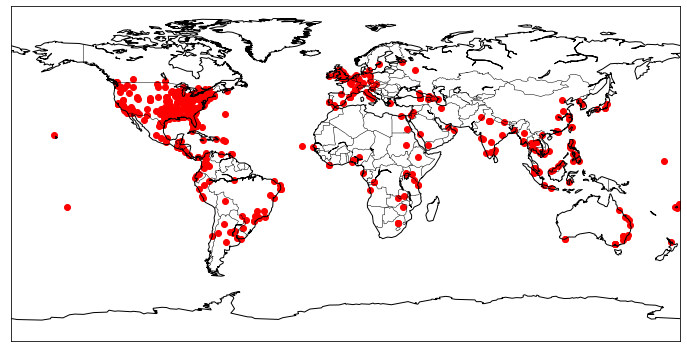

In [6]:
def scatterplot_world(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    for coordinates, color in zip(coordinates_list, colors):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_plotter.scatter(longitudes, latitudes, latlon=True, color=color)
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    _ = plt.show()
    
scatterplot_world(map_plotter, [coordinates], ["r"])

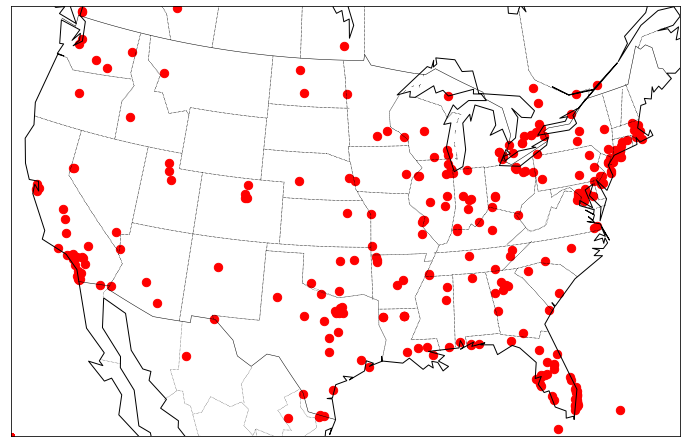

In [7]:
def scatterplot_us(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                      llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, 
                      lat_1=33,lat_2=45)
    for coordinates, color in zip(coordinates_list, colors):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_plotter.scatter(longitudes, latitudes, latlon=True, color=color)
    map_lcc.scatter(longitudes, latitudes, latlon=True, s=70, color='r')
    map_lcc.drawcoastlines()
    map_lcc.drawcountries()
    map_lcc.drawstates(linestyle="dotted")
    _ = plt.show()
    
scatterplot_us(map_plotter, [coordinates], ["r"])

## KMeans Clustering

### Determine K using Elbow method

Optimum choice of k seems to be 3 from the plot below.

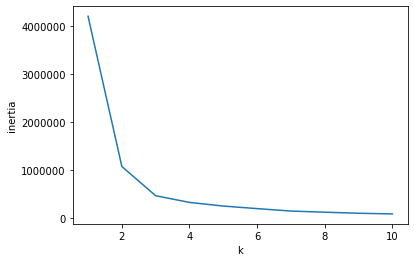

In [8]:
k_choices = np.arange(1, 11)
inertia_values = [KMeans(k).fit(coordinates).inertia_ for k in k_choices]

plt.plot(k_choices, inertia_values)
plt.xlabel("k")
plt.ylabel("inertia")
_ = plt.show()

In [9]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(coordinates)

coordinates_pred = headlines_df[["latitude", "longitude"]].values
headlines_df["cluster"] = model.predict(coordinates_pred)

headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,0
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


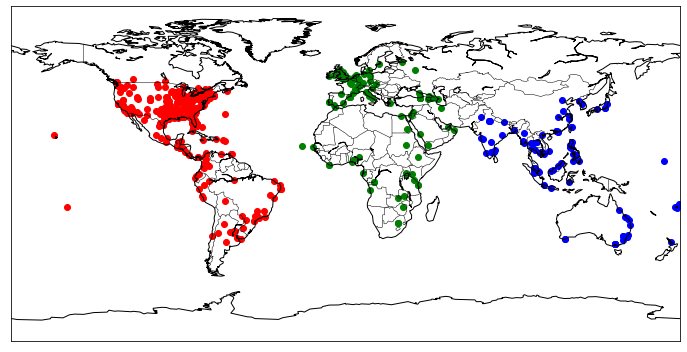

In [10]:
coordinates_list = [
    headlines_df[headlines_df["cluster"]==0][["latitude", "longitude"]].values,
    headlines_df[headlines_df["cluster"]==1][["latitude", "longitude"]].values,
    headlines_df[headlines_df["cluster"]==2][["latitude", "longitude"]].values
]
colors = ["r", "b", "g"]
scatterplot_world(map_plotter, coordinates_list, colors)

## DBSCAN

### Determine best eps

From the supplied documentation:

>Generally speaking, if we are clustering random cities spread out across the Earth, then we can set the min_samples and eps parameters to equal 3 cities and 250 miles, respectively. This will assume each cluster holds a city that is within 250 miles of at-least 3 other clustered cities. For a more regional location distribution, a lower eps value will be required.

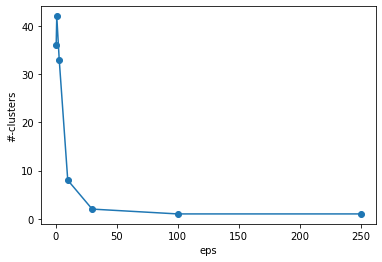

In [11]:
eps_choices = [0.5, 1, 3, 10, 30, 100, 250]
num_clusters = [len(np.unique(
    DBSCAN(min_samples=3, eps=eps).fit_predict(coordinates))) for eps in eps_choices]

plt.plot(eps_choices, num_clusters, marker='o')
plt.xlabel("eps")
plt.ylabel("#-clusters")
_ = plt.show()

In [12]:
num_clusters

[36, 42, 33, 8, 2, 1, 1]

### DBSCAN (eps=10, num_clusters=8)

In [13]:
model_1 = DBSCAN(min_samples=3, eps=10)
clusters = model_1.fit_predict(coordinates)
headlines_df["cluster"] = clusters
headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


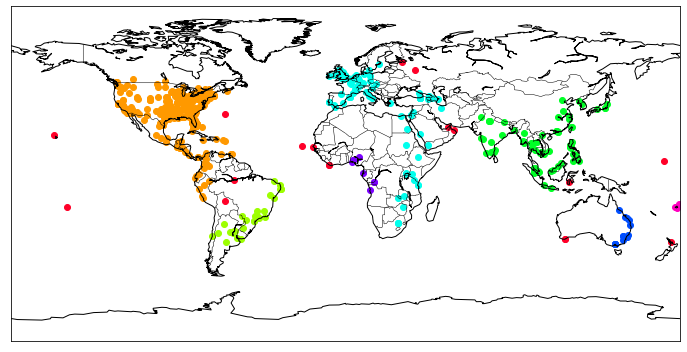

In [14]:
coordinates_list, colors = [], []

cluster_ids = np.unique(headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    coordinates_list.append(
        headlines_df[headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)

### DBSCAN (metric: Great Circle Distance)

* [Formula for Great Circle Distance](https://en.wikipedia.org/wiki/Great-circle_distance) on Wikipedia.
* Provided by Scikit-Learn as [Haversine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html) but looks like its new or deprecated, not available in the scikit-learn version provided for this project.

So we have to build this ourselves and call DBSCAN with `metric="precomputed"`.

We want to try and reuse the same hyperparameters as our previous DBSCAN, so we should try to return the distances in the same order as the default euclidean distances we computed for our previous example.

In [15]:
def great_circle_distances(coordinates):
    D = np.zeros((len(coordinates), len(coordinates)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            if i >= j:
                continue
            # values are in degrees, 
            # latitude is from (-90 to +90) => (-pi/2 to pi/2) radians
            # longitude is from (-180 to 180) => (-pi to pi) radians
            lat1, lon1 = coordinates[i]
            lat2, lon2 = coordinates[j]
            lat1_r = lat1 * np.pi / 90
            lon1_r = lon1 * np.pi / 180
            lat2_r = lat2 * np.pi / 90
            lon2_r = lon2 * np.pi / 180
#             lat1_r, lon1_r = coordinates[i]
#             lat2_r, lon2_r = coordinates[j]
            lat_diff = np.abs(lat1_r - lat2_r)
            angle = (np.sin(lon1_r) * np.sin(lon2_r) + 
                     np.cos(lon1_r) * np.cos(lon2_r) * np.cos(lat_diff))
#             if angle < -1 and angle > 1:
#                 if angle < 0:
#                     angle = -1
#                 else:
#                     angle = 1
            sigma = np.arccos(angle)
            
#             km = 6371 * sigma
#             D[i, j] = km
#             D[j, i] = km
            D[i, j] = sigma * 100
            D[j, i] = sigma * 100

    return np.nan_to_num(D)
            
distances = great_circle_distances(coordinates)
distances.shape

/Users/palsujit/anaconda3/envs/disease/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in arccos


(600, 600)

In [16]:
euc_dists = euclidean_distances(coordinates)
euc_dists.shape

(600, 600)

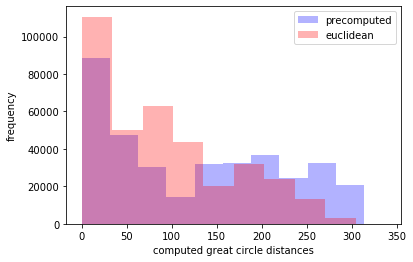

In [17]:
plt.hist(distances.reshape(-1), bins=10, color="blue", alpha=0.3, label="precomputed")
plt.hist(euc_dists.reshape(-1), bins=10, color="red", alpha=0.3, label="euclidean")
plt.legend(loc="best")
plt.xlabel("computed great circle distances")
plt.ylabel("frequency")
_ = plt.show()

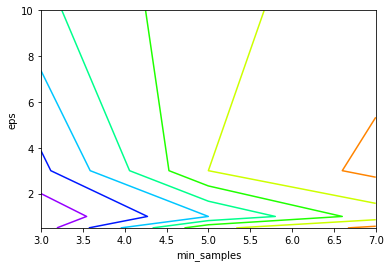

In [18]:
min_sample_choices = [3, 5, 7]
eps_choices = eps_choices = [0.5, 1, 3, 10]

X = np.zeros((len(min_sample_choices), len(eps_choices)))
Y = np.zeros((len(min_sample_choices), len(eps_choices)))
Z = np.zeros((len(min_sample_choices), len(eps_choices)))
for i, min_sample in enumerate(min_sample_choices):
    for j, eps in enumerate(eps_choices):
        model = DBSCAN(min_samples=min_sample, eps=eps, metric="precomputed")
        clusters = model.fit_predict(distances)
        X[i, j] = min_sample
        Y[i, j] = eps
        Z[i, j] = len(np.unique(clusters))

plt.contour(X, Y, Z, cmap="gist_rainbow")
plt.xlabel("min_samples")
plt.ylabel("eps")
_ = plt.show()

In [19]:
data = []
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        data.append([X[i, j], Y[i, j], Z[i, j]])
hyperparameters_df = pd.DataFrame(data, columns=["min_sample", "eps", "num_clusters"])
hyperparameters_df.head(len(hyperparameters_df))

,min_sample,eps,num_clusters
0,3.0,0.5,34.0
1,3.0,1.0,35.0
2,3.0,3.0,29.0
3,3.0,10.0,21.0
4,5.0,0.5,13.0
5,5.0,1.0,24.0
6,5.0,3.0,12.0
7,5.0,10.0,13.0
8,7.0,0.5,7.0
9,7.0,1.0,14.0


In [20]:
model_2 = DBSCAN(min_samples=7, eps=10, metric="precomputed")
clusters = model_2.fit_predict(distances)

In [21]:
cluster_ids, cluster_counts = np.unique(clusters, return_counts=True)
for cluster_id, cluster_count in zip(cluster_ids, cluster_counts):
    print(cluster_id, cluster_count)

-1 115
0 348
1 18
2 48
3 23
4 8
5 10
6 9
7 10
8 11


In [22]:
headlines_df["cluster"] = clusters
headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,-1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


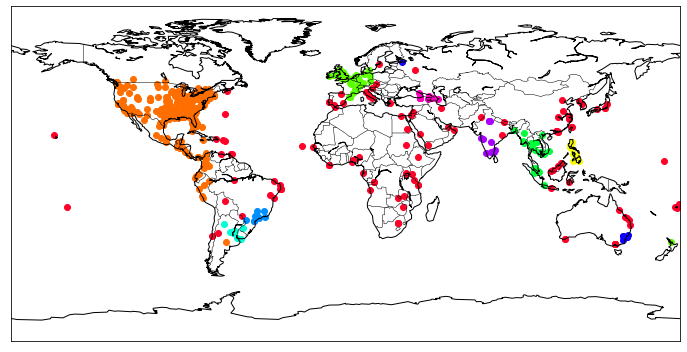

In [23]:
coordinates_list, colors = [], []

cluster_ids = np.unique(headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
#     if cluster_ids[i] == -1:
#         continue
    coordinates_list.append(
        headlines_df[headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)